# Algoritmo de BackPropagation multiclase

Este codigo se utilizará para entrenar la red neuronal de clasificacion de Nuestras Caras



### Código en Python del Algoritmo de BackPropagation

La clase del dataset debe ser categorica
Existe una clase en Python que resuelve el problema

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/.drive/My Drive/DMA"
!mkdir -p "/content/buckets"
!ln -s "/content/.drive/My Drive/DMA" /content/buckets/b1

Mounted at /content/drive


In [ ]:
# instalo  itables solo si no esta instalado
!pip show itables >/dev/null || pip install itables

In [3]:
import polars as pl
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import os
import pickle
from functools import reduce
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)


In [4]:
class perceptron_plot:
    def __init__(self, X, Y, delay) -> None:
        self.X = X
        self.Y = Y
        self.delay = delay
        x1_min = np.min(X[:, 0])
        x2_min = np.min(X[:, 1])
        x1_max = np.max(X[:, 0])
        x2_max = np.max(X[:, 1])
        self.x1_min = x1_min - 0.1 * (x1_max - x1_min)
        self.x1_max = x1_max + 0.1 * (x1_max - x1_min)
        self.x2_min = x2_min - 0.1 * (x2_max - x2_min)
        self.x2_max = x2_max + 0.1 * (x2_max - x2_min)
        self.fig = plt.figure(figsize=(10, 8))
        self.ax = self.fig.subplots()
        self.ax.set_xlim(self.x1_min, self.x1_max, auto=False)
        self.ax.set_ylim(self.x2_min, self.x2_max, auto=False)

    def graficarVarias(self, W, x0, epoch, error) -> None:
        display.clear_output(wait=True)
        plt.cla()
        self.ax.set_xlim(self.x1_min, self.x1_max)
        self.ax.set_ylim(self.x2_min, self.x2_max)
        plt.title(f'epoch {epoch}  reg {error:.2E}')
        unique_labels = np.unique(self.Y)
        label_mapping = {label: i for i, label in enumerate(unique_labels)}
        numerical_labels = np.array([label_mapping[label] for label in self.Y])

        scatter = self.ax.scatter(self.X[:, 0], self.X[:, 1], c=numerical_labels, s=20)

        for i in range(len(x0)):
            vx2_min = -(W[i, 0] * self.x1_min + x0[i]) / W[i, 1]
            vx2_max = -(W[i, 0] * self.x1_max + x0[i]) / W[i, 1]
            self.ax.plot([self.x1_min, self.x1_max], [vx2_min, vx2_max], linewidth=2, color='red', alpha=0.5)

        display.display(plt.gcf())
        time.sleep(self.delay)

In [5]:
# definicion de las funciones de activacion
# y sus derivadas agregando las versiones VECTORIZADAS
def func_eval(fname, x):
    if fname == "purelin":
        return x
    elif fname == "logsig":
        return 1.0 / (1.0 + np.exp(-x))
    elif fname == "tansig":
        return 2.0 / (1.0 + np.exp(-2.0 * x)) - 1.0
    else:
        raise ValueError(f"Función de activación no soportada: {fname}")

# version vectorizada de func_eval
func_eval_vec = np.vectorize(func_eval)

def deriv_eval(fname, y):
    if fname == "purelin":
        return 1.0
    elif fname == "logsig":
        return y * (1.0 - y)
    elif fname == "tansig":
        return 1.0 - y * y

# version vectorizada de deriv_eval
deriv_eval_vec = np.vectorize(deriv_eval)

### Clase  multiperceptron
entrenar, predecir

In [6]:
# Definicion de la clase de multiperceptron (red neuronal con múltiples capas ocultas)

class multiperceptron(object):
    """Multiperceptron class"""

    def _red_init(self, semilla) -> None:

        niveles = self.red['arq']['layers_qty']
        np.random.seed(semilla)

        for i in range(niveles):
           nivel = dict()
           nivel['id'] = i
           nivel['last'] = (i==(niveles-1))
           nivel['size'] = self.red["arq"]["layers_size"][i]
           nivel['func'] = self.red["arq"]["layers_func"][i]

           # Se determina cuántas entradas recibe la capa actual
           if( i==0 ):
              entrada_size = self.red['arq']['input_size']
           else:
              entrada_size =  self.red['arq']['layers_size'][i-1]

           salida_size =  nivel['size']

           # los pesos, inicializados random
           nivel['W'] = np.random.uniform(-0.5, 0.5, [salida_size, entrada_size])
           nivel['w0'] = np.random.uniform(-0.5, 0.5, [salida_size, 1])

           # los momentos, inicializados en CERO
           nivel['W_m'] = np.zeros([salida_size, entrada_size])
           nivel['w0_m'] = np.zeros([salida_size, 1])

           self.red['layer'].append(nivel)

    # constructor generico
    def __init__(self) -> None:
        self.data = dict()
        self.red = dict()
        self.carpeta = ""

    # inicializacion full
    def inicializar(self, df, campos, clase, hidden_layers_sizes, layers_func,
                 semilla, carpeta) -> None:

        # Procesamiento de los datos de entrada (features)
        self.data['X'] = np.array(df.select(campos))
        # Normalización (escalado) de los datos para que los atributos tengan media 0 y desviación estándar 1
        X_mean = self.data['X'].mean(axis=0)
        X_sd = self.data['X'].std(axis=0)
        self.data['X'] = (self.data['X'] - X_mean)/X_sd

        #  Procesamiento de etiquetas Ylabel en  numpy
        label =df.select(clase)
        self.data['Ylabel'] = np.array(label).reshape(len(label))

        # one-hot-encoding de Y . Realiza la codificacion "one hot" de las etiquetas (Convierte cada categoría única en una columna binaria separada y representa la presencia con 1 y la ausencia con 0.)
        col_originales = df.columns
        self.data['Y'] = np.array( df.to_dummies(clase).drop(col_originales, strict=False) )
        col_dummies = sorted( list( set(df.to_dummies(clase).columns) -  set(col_originales)))
        clases_originales = reduce(lambda acc, x: acc + [x[(len(clase)+1):]], col_dummies, [])

        # Construcción de la arquitectura de la red
        tamanos = hidden_layers_sizes
        tamanos.append(self.data['Y'].shape[1])

        arquitectura = {
             'input_size' : self.data['X'].shape[1],
             'input_mean' : X_mean,
             'input_sd' :  X_sd,
             'output_values' : clases_originales,
             'layers_qty' : len(hidden_layers_sizes),
             'layers_size' : tamanos ,
             'layers_func' : layers_func,
        }

        self.red['arq'] = arquitectura

        # inicializo  work . Inicialización de información de entrenamiento
        self.red['work'] = dict()
        self.red['work']['epoch'] = 0
        self.red['work']['MSE'] = float('inf')
        self.red['work']['train_error_rate'] = float('inf')

        # Preparación de las capas y pesos
        self.red['layer'] = list()
        self._red_init(semilla)

        # grabo el entorno. Guardar el entorno en disco
        self.carpeta = carpeta
        os.makedirs(self.carpeta, exist_ok=True)
        with open(self.carpeta+"/data.pkl", 'wb') as f:
            pickle.dump(self.data, f)

        with open(self.carpeta+"/red.pkl", 'wb') as f:
            pickle.dump(self.red, f)


    # Algoritmo Backpropagation
    def  entrenar(self, epoch_limit, MSE_umbral,
               learning_rate, lr_momento, save_frequency,
               retomar=True) -> None:


        if( retomar):
            with open(self.carpeta+"/data.pkl", 'rb') as f:
              self.data = pickle.load(f)
            with open(self.carpeta+"/red.pkl", 'rb') as f:
              self.red = pickle.load(f)


        # inicializaciones del bucle principal del backpropagation
        epoch = self.red['work']['epoch']
        MSE = self.red['work']['MSE']

        # inicializacion del grafico de evolucion
        grafico = perceptron_plot(X=self.data['X'], Y=self.data['Ylabel'], delay=0.1)

        # Parametros de control
        Xfilas = self.data['X'].shape[0]
        niveles = self.red["arq"]["layers_qty"]

        while ( MSE > MSE_umbral) and (epoch < epoch_limit) :
          epoch += 1


          # Entrenamiento Registro por Registro.
          # recorro siempre TODOS los registros de entrada
          for fila in range(Xfilas):
             # fila es el registro actual
             x = self.data['X'][fila:fila+1,:]
             clase = self.data['Y'][fila:fila+1,:]


             # FORWARD PROPAGATION: propagar el x hacia adelante.

             entrada = x.T
             vsalida =  [0] *(niveles)
             # etapa forward - recorro hacia adelante, nivel a nivel
             for i in range(niveles):
               estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
               vsalida[i] =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
               entrada = vsalida[i]  # para la proxima vuelta


             # BACKPROPAGATION — cálculo de errores
             # etapa backward - calculo los errores en la capa hidden y la capa output
             verror =  [0] *(niveles+1)
             verror[niveles] = clase.T - vsalida[niveles-1]

             i = niveles-1
             verror[i] = verror[i+1] * deriv_eval_vec(self.red['layer'][i]['func'], vsalida[i])

             for i in reversed(range(niveles-1)):
               verror[i] = deriv_eval_vec(self.red['layer'][i]['func'], vsalida[i])*(self.red['layer'][i+1]['W'].T @ verror[i+1])

             # Actualización de pesos y sesgos: ya tengo los errores que comete cada capa corregir matrices de pesos, voy hacia atras
             # backpropagation
             entrada = x.T
             for i in range(niveles):
               self.red['layer'][i]['W_m'] = learning_rate *(verror[i] @ entrada.T) + lr_momento *self.red['layer'][i]['W_m']
               self.red['layer'][i]['w0_m'] = learning_rate * verror[i] + lr_momento * self.red['layer'][i]['w0_m']

               self.red['layer'][i]['W']  =  self.red['layer'][i]['W'] + self.red['layer'][i]['W_m']
               self.red['layer'][i]['w0'] =  self.red['layer'][i]['w0'] + self.red['layer'][i]['w0_m']
               entrada = vsalida[i]  # para la proxima vuelta


          # Valuación del modelo después de un Epoch
          entrada = self.data['X'].T
          for i in range(niveles):
            estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
            salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
            entrada = salida  # para la proxima vuelta

          # calculo el error cuadratico medio TODOS los X del dataset
          MSE= np.mean( (self.data['Y'].T - salida)**2 )

          # Visualización y guardado periódico: cada "save_frequency" Epochs (o al finalizar)
          if( epoch % save_frequency == 0 ) or ( MSE <= MSE_umbral) or (epoch >= epoch_limit) :
              # grafico
              W = self.red['layer'][0]['W']
              w0 = self.red['layer'][0]['w0']
              grafico.graficarVarias(W, w0.T[0], epoch, MSE)
              # almaceno en work
              self.red['work']['epoch'] = epoch
              self.red['work']['MSE'] = MSE
              prediccion = np.argmax( salida.T, axis=1)
              # prediccion
              out = np.array(self.red["arq"]['output_values'])
              error_rate = np.mean( self.data['Ylabel'] != out[prediccion])
              self.red["work"]['train_error_rate'] = error_rate # error_rate != error cuadratico medio


              # grabo a un archivo la red neuronal ENTRENADA por donde esté
              with open(carpeta+"/red.pkl", 'wb') as f:
                 pickle.dump(self.red, f)

        return (epoch, MSE, self.red['work']['train_error_rate'] )


    # predigo a partir de modelo recien entrenado
    def  predecir(self, df_new, campos, clase) -> None:


        niveles = self.red['arq']['layers_qty']

        # etapa forward
        # recorro hacia adelante, nivel a nivel
        X_new =  np.array( df_new.select(campos))


        # estandarizo manualmente con las medias y desvios que almacene durante el entrenamiento
        X_new = (X_new - self.red['arq']['input_mean'])/self.red['arq']['input_sd']

        # grafico los datos nuevos
        Ylabel_new =df_new.select(clase)
        Ylabel_new = np.array(Ylabel_new).reshape(len(Ylabel_new))

        grafico = perceptron_plot(X=X_new, Y=Ylabel_new, delay=0.1)
        W = self.red['layer'][0]['W']
        w0 = self.red['layer'][0]['w0']
        grafico.graficarVarias(W, w0.T[0], epoch, MSE)

        # la entrada a la red,  el X que es TODO  x_new
        entrada = X_new.T

        for i in range(niveles):
          estimulos = self.red['layer'][i]['W'] @ entrada + self.red['layer'][i]['w0']
          salida =  func_eval_vec(self.red['layer'][i]['func'], estimulos)
          entrada = salida  # para la proxima vuelta

        # me quedo con la neurona de la ultima capa que se activio con mayor intensidad
        pred_idx = np.argmax( salida.T, axis=1)
        pred_raw = np.max( salida.T, axis=1)
        # calculo error_rate
        out = np.array(self.red['arq']['output_values'])
        error_rate = np.mean(np.array(df_new.select(clase) != out[pred_idx]))

        return (out[pred_idx], pred_raw, error_rate)


    # cargo un modelo ya entrenado, grabado en carpeta
    def cargar_modelo(self, carpeta) -> None:
        self.carpeta = carpeta

        with open(self.carpeta+"/red.pkl", 'rb') as f:
          self.red = pickle.load(f)

        return (self.red['work']['epoch'],
                self.red['work']['MSE'],
                self.red['work']['train_error_rate'] )


## 1 Lectura del Dataset

En este humilde y restringida version, la clase del dataset debe ser categorica, no es capaz de trabajar con clases continuas.
La clase categorica puede ser  n-aria

In [7]:
# Lectura del dataset con la moderna libreria Polars  (Pandas debe extinguirse!)

df = pl.read_csv('/content/drive/MyDrive/DMA/datos_isomap.csv', separator='\t')
print(df.head())


shape: (5, 51)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC48      ┆ PC49      ┆ PC50      ┆ Etiqueta │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1043.2956 ┆ 5320.7309 ┆ 305.40388 ┆ -6142.031 ┆ … ┆ -1400.300 ┆ 221.67546 ┆ -465.9245 ┆ Noelia R │
│ 16        ┆ 37        ┆ 9         ┆ 766       ┆   ┆ 857       ┆ 5         ┆ 62        ┆          │
│ 1242.1559 ┆ 6818.5571 ┆ 2090.4617 ┆ -900.1169 ┆ … ┆ -367.8813 ┆ -165.1627 ┆ 1334.1494 ┆ Noelia R │
│           ┆ 08        ┆ 79        ┆ 07        ┆   ┆ 48        ┆ 7         ┆ 91        ┆          │
│ -1035.976 ┆ 2679.2301 ┆ -410.1646 ┆ -2732.913 ┆ … ┆ -351.4430 ┆ -6.923909 

### 1.1 Particion  training/testing



*   Es valido cambiar la *semilla_particion* para probar distintos <test, train> y asi estimar con mas precisión el error rate en testing  (Montecarlo Estimation)



In [46]:
# particion del dataset en training/testing

semilla_particion = 19770112
pct_train = 0.75  # ratio de registros que va a training


def train_test_split_df(df, seed=0, test_size=0.2):
    return df.with_columns(
        pl.int_range(pl.len(), dtype=pl.UInt32)
        .shuffle(seed=seed)
        .gt(pl.len() * test_size)
        .alias("split")
    ).partition_by("split", include_key=False)


(df_train, df_test) = train_test_split_df(df,
                                          seed=semilla_particion,
                                          test_size=1-pct_train)

# imprimo los tamaños
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (2564, 51)
Test: (856, 51)


## 2  Entrenamiento del modelo

### 2.1  Inicializacion de la neural network



*   Es valido cambiar la *semilla_red* para arrancar el entrenamiento con distintas rectas iniciales


In [47]:
# defino la red multiperceptron
carpeta = "/content/buckets/b1/nn50(1c-14n)/"  # cambiar con cada corrida
semilla_red =  770153

# la capa oculta y la final tienen ambas de activacion
mp = multiperceptron()
mp.inicializar(
    df=df_train,
    campos=df_train.columns[:-1],
    clase="Etiqueta",
    hidden_layers_sizes=[14],  # no va la capa final, solo hidden layers
    layers_func=['logsig','logsig'], # funciones de activacion de cada capa
    semilla=semilla_red,
    carpeta = carpeta
    )

### 2.2 Entrenamiento de la neural network = backpropagation

Aqui se hace el trabajo pesado de entrenar la red neuronal

Es necesario experimentar con


*   learning_rate
*   lr_momento
*   epoch_limit  y MSE_umbral



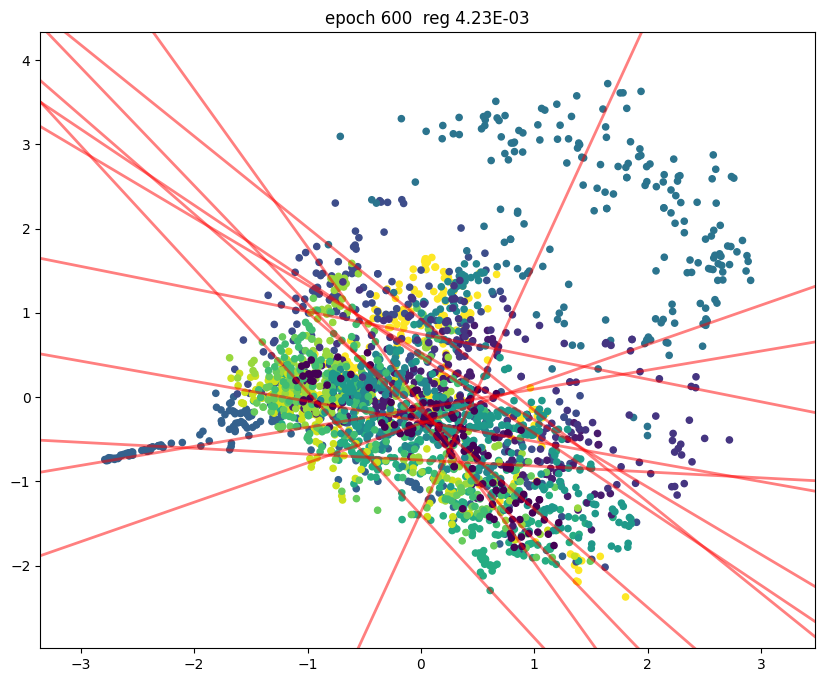

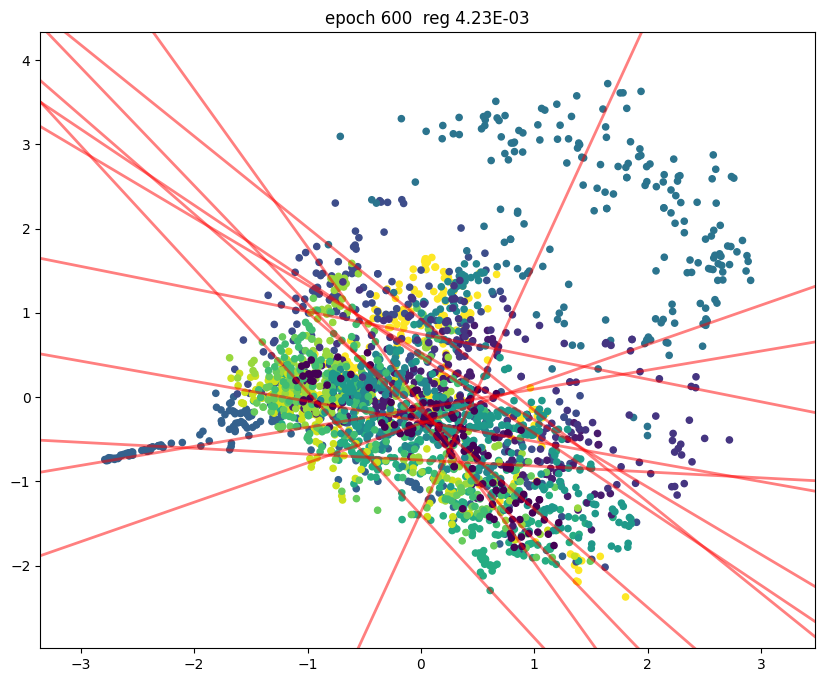

In [48]:
# el entrenamiento
(epoch, MSE, train_error_rate) = mp.entrenar(

    epoch_limit=600,
    MSE_umbral=0.0001,
    learning_rate=0.2,
    lr_momento=0.2,
    save_frequency=100,
    retomar=True)                                       # Si True, el entrenamiento continúa desde donde se dejó previamente (cargando archivos guardados data.pkl, red.pkl). Si False, comenzará desde cero.


#### Visualizacion de los resultados de la salida del entrenamiento de la red

In [49]:
# las metricas basica de la red
print("epoch :", epoch)
print("MSE :", MSE)
print("train_error_rate :", train_error_rate)

epoch : 600
MSE : 0.00422633479860345
train_error_rate : 0.04563182527301092


In [ ]:
# la primera hidden layer
print("W :", mp.red["layer"][0]["W"])
print()
print("w0 :", mp.red["layer"][0]["w0"])

### 2.3 Entrenamiento en caso de retomar



*   Si se cortó el colab
*   Si quiero extender la corrida a mas epochs
*   Si quiero cambiar el learninh_rate
*   Si quiero cambiar el MSE_umbral



In [ ]:
(epoch, MSE, train_error_rate) = mp.entrenar(
    epoch_limit=1800, # aumento
    MSE_umbral=0.001,
    learning_rate=0.05,
    lr_momento=0.05,
    save_frequency=100,
    retomar=True)

Visualizacion de los resultados de salida de un post entrenamiento

In [ ]:
print("epoch :", epoch)
print("MSE :", MSE)
print("train_error_rate :", train_error_rate)

In [ ]:
# la primera hidden layer
print("W :", mp.red["layer"][0]["W"])
print()
print("w0 :", mp.red["layer"][0]["w0"])

## 3  Prediccion en los datos de Testing


Se muestran los datos de testing, que son distintos a los de training

### 3.1 Prediccion en caliente

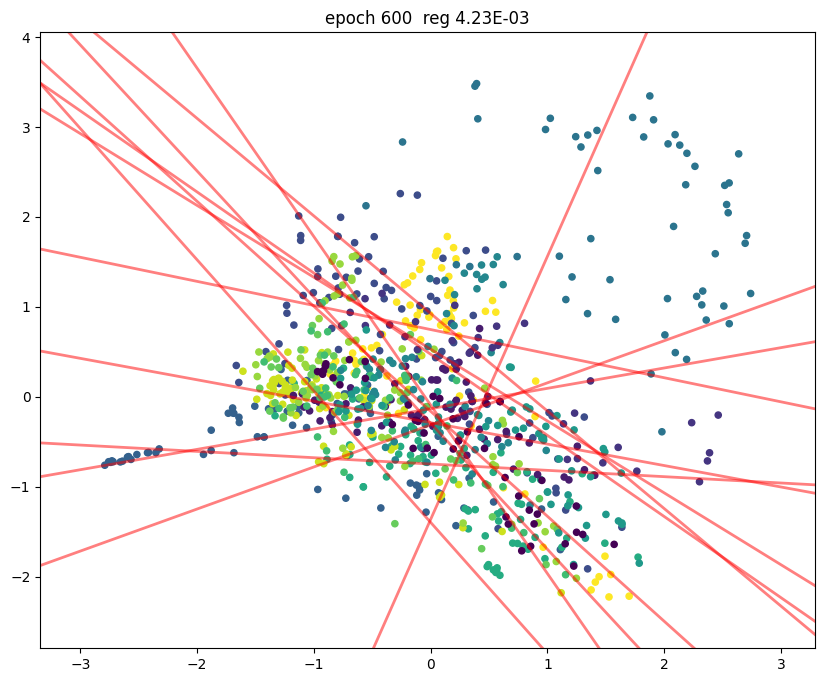

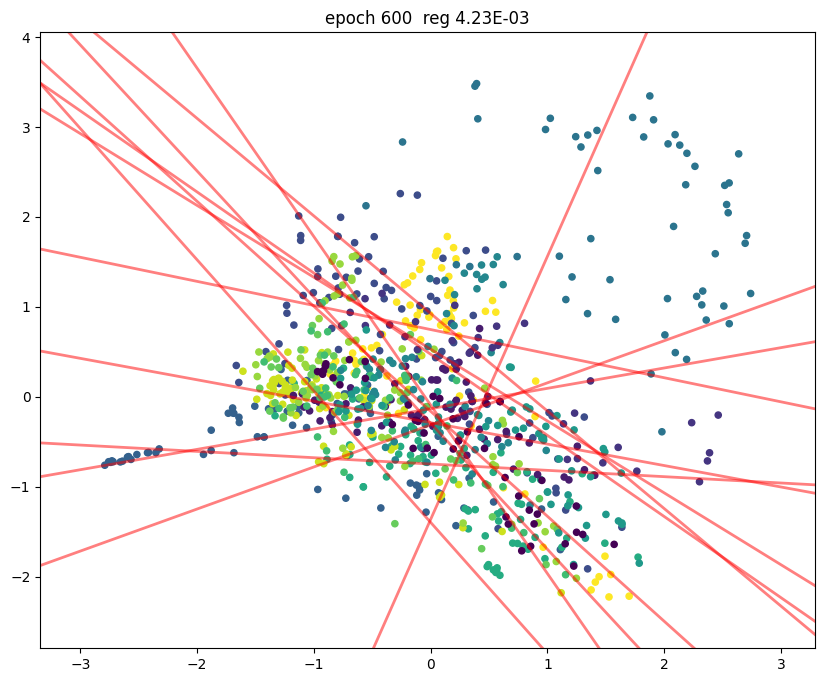

In [50]:
# aplico la red entrenada al dataset de testing


(y_hat,y_raw, test_error_rate) = mp.predecir(df_new=df_test, campos=df_test.columns[:-1], clase='Etiqueta') # se llama al método .predecir() del objeto mp, que es una instancia de la clase multiperceptron.


#### Visualizacion del error en testing

In [51]:
print("error_rate (train, test): ",  train_error_rate, test_error_rate)    # Muestra las tasas de error de entrenamiento (train_error_rate, obtenido al finalizar el entrenamiento) y de prueba (test_error_rate, recién calculado).


error_rate (train, test):  0.04563182527301092 0.17523364485981308


#### Visualizacion de la prediccion en testing

In [52]:
tb_salida_test = pl.DataFrame( {"clase":df_test["Etiqueta"], "pred":y_hat, "y_raw":y_raw })  # construye una nueva tabla (tb_salida_test) que contiene: "clase"	Clase verdadera (y) del conjunto de prueba.
                                                                                      # "pred"	Clase predicha por la red (y_hat).
                                                                                      # "y_raw"	Valor de activación de la neurona más activa (nivel de confianza o intensidad de la predicción).
tb_salida_test

Loading ITables v2.4.0 from the internet... (need help?)


# FINAL TRAINING: Con todos los datos originales

## Lectura del dataset original completo (preprocesado)

In [ ]:
# Lectura del dataset con la moderna libreria Polars  (Pandas debe extinguirse!)

df_final_traning = pl.read_csv('/content/.drive/MyDrive/DMA/resultados_isomap_detectadas.csv', separator='\t')
print(df.head())


shape: (5, 51)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ PC1       ┆ PC2       ┆ PC3       ┆ PC4       ┆ … ┆ PC48      ┆ PC49      ┆ PC50      ┆ Etiqueta │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -6498.416 ┆ 1454.1695 ┆ -556.0133 ┆ -4561.883 ┆ … ┆ 319.67484 ┆ -34.00184 ┆ 260.65940 ┆ Federico │
│ 966       ┆ 81        ┆ 21        ┆ 999       ┆   ┆ 3         ┆           ┆ 8         ┆          │
│ -4451.959 ┆ -74.84229 ┆ -160.9150 ┆ -4405.612 ┆ … ┆ -743.5626 ┆ 263.89511 ┆ 1.072335  ┆ Federico │
│ 119       ┆ 7         ┆ 84        ┆ 181       ┆   ┆ 48        ┆ 5         ┆           ┆          │
│ -7838.698 ┆ 1239.1468 ┆ -107.0379 ┆ -3219.058 ┆ … ┆ 244.74649 ┆ -315.7662 

## Inicializacion de la neural network

In [ ]:
# defino la red multiperceptron
carpeta = "/content/buckets/b1/nn51(1c-14n)/"  # cambiar con cada corrida
semilla_red = 19770112  # define las rectas iniciales

# la capa oculta y la final tienen ambas de activacion
mp = multiperceptron()
mp.inicializar(
    df=df_final_traning,
    campos=df_train.columns[:-1],
    clase="Etiqueta",                 # La calse es Etiqueta
    hidden_layers_sizes=[14],  # no va la capa final, solo hidden layers
    layers_func=['logsig','logsig'], # funciones de activacion de cada capa
    semilla=semilla_red,
    carpeta = carpeta
    )

## Entrenamiento de la neural network = backpropagation

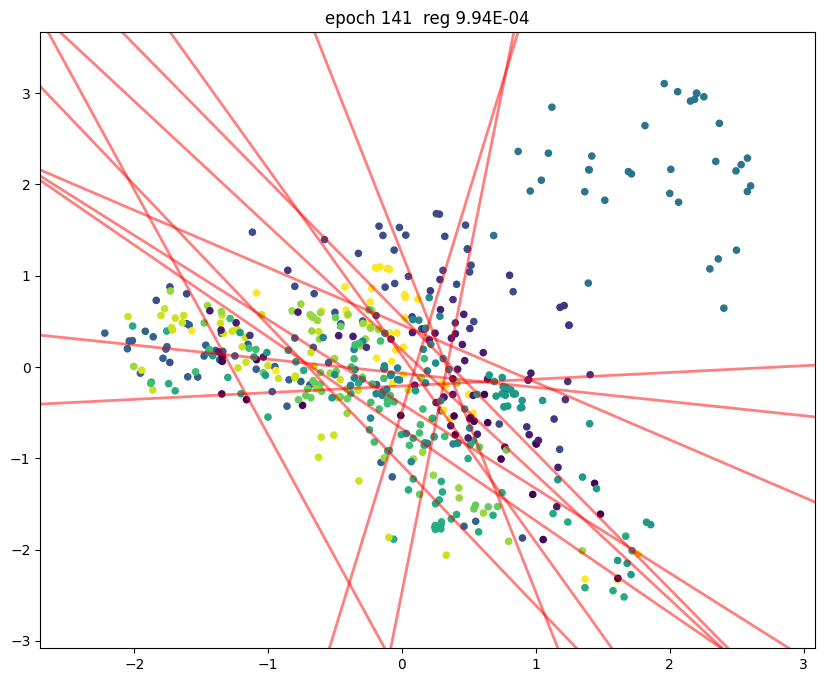

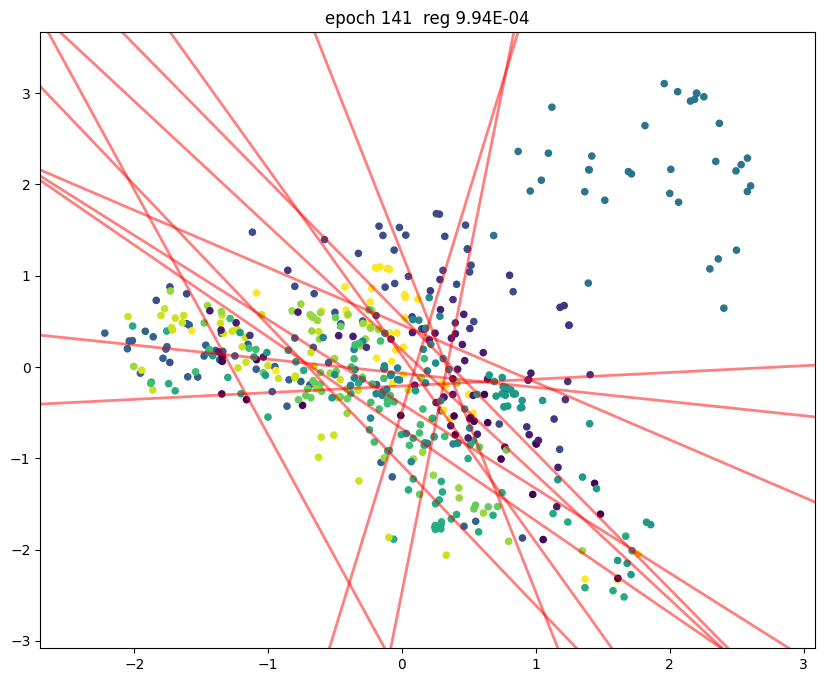

In [ ]:
# el entrenamiento
(epoch, MSE, train_error_rate) = mp.entrenar(

    epoch_limit=600,
    MSE_umbral=0.001,
    learning_rate=0.2,
    lr_momento=0.2,
    save_frequency=100,
    retomar=False)

## Visualizacion de los resultados de la salida del entrenamiento de la red

In [ ]:
# las metricas basica de la red
print("epoch :", epoch)
print("MSE :", MSE)
print("train_error_rate :", train_error_rate)

epoch : 141
MSE : 0.0009935644838181643
train_error_rate : 0.008113590263691683


Visualizacion de la prediccion en Final Traning



In [ ]:
tb_salida_test = pl.DataFrame( {"clase":df_test["Etiqueta"], "pred":y_hat, "y_raw":y_raw })  # construye una nueva tabla (tb_salida_test) que contiene: "clase"	Clase verdadera (y) del conjunto de prueba.
                                                                                      # "pred"	Clase predicha por la red (y_hat).
                                                                                      # "y_raw"	Valor de activación de la neurona más activa (nivel de confianza o intensidad de la predicción).
tb_salida_test

Loading ITables v2.4.0 from the internet... (need help?)


## 4 Prediccion en datos NUEVOS


*   La red fue entrenada en el pasado, y se grabó al drive
*   Ya no esta disponible la sesion donde se entreno
*   No quiero volver a entrenar de cero

In [ ]:
# cargo datos NUEVOS
df_new = pl.read_csv('https://storage.googleapis.com/open-courses/austral2025-af91/nuevos02.txt', separator='\t')
df_new.shape

In [ ]:
# cargo modelo grabado y lo aplico a los datos nuevos

carpeta = "/content/buckets/b1/nn01/"  # la carpeta del modelo entrenado

mp_frio = multiperceptron()
(epoch, MSE, train_error_rate) = mp_frio.cargar_modelo(carpeta)

(y_hat, y_raw, new_error_rate) = mp_frio.predecir(df_new=df_new, campos=['x1', 'x2'], clase='y')

#### Visualizacion del error modeloa aplicado a datos nuevos

In [ ]:
print("error_rate (train, new): ",  train_error_rate, new_error_rate)

#### Visualizacion de la prediccion en datos nuevos

In [ ]:
tb_salida_new = pl.DataFrame( {"clase":df_new["y"], "pred":y_hat, "y_raw":y_raw })
tb_salida_new